**INPUTS**  
db_multiclass_sample.csv  \
flights_scaled.csv  \
**OUTPUTS**\
db_multiclass_data.csv\
Multiclass.sav

# 2. Multiclass classification
**Goal:** predict the type of delay for delayed flights  

**Description**: This notebooks was used to create a ML algorythm that predicts the type of delay on delayed flights (arrival delays >= 15min). The input data comes from the file *flights_scaled.csv* that had the following transformations
- drop rows where `DELAY_TYPE` (value is 0 for flights <15min)
- drop column `ARR_DELAY` 
- drop column ` CANCELLED` 

**Target variable:**\
`DELAY_TYPE`

This feature contaings values from 1 to 5 corresponding to the following delay types and representtions in the dataset:
- 1: `CARRIER_DELAY` 26.7%
- 2: `WEATHER_DELAY` 3.3%
- 3: `NAS_DELAY` 30%
- 4: `SECURITY_DELAY` 0.17%
- 5: `LATE_AIRCRAFT_DELAY` 39%

**Notes**:  
We can use a custom threshold on predicting probabilities.  
We could look at an oversampler and Undersampler method: SMOTE combined with RandomUnderSampler on the training datasets in this step [Article on how to perform SMOTE](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)  
We could a [calibration algo on the predicted prbobabilities](https://machinelearningmastery.com/calibrated-classification-model-in-scikit-learn/)  

**Steps**:
1. Pick evaluation metrics and models to try
2. Spot check different algos based on **a sample data** using cross validate
3. Select a model
4. Split training/testing data on **the whole dataset**
5. Tune hyperparameters on selected algo on **training data** using grid search
6. Train selected algo & parameters on the **training data**
7. Test performance on **testing data**
8. Save with pickle

## 1. Pick evaluation metrics and models to try
**Evaluation metrics for multi-class classification**  
- F1 score (weighted)  
- Balanced accuracy   
- Auc score

**Models to try**
- Naive algorythm (used as a baseline model):  
Predict the majority class for all

- Linear algorythms:  
Logistic Regression   
LDA  
Polynomial regression  

- Support Vector Machines algorythms:  
Support Vector Classification

- Ensemble algorythms:  
Random forest  
Stochastic Gradient Boosting 
XGBoost

## 2. Spot check different algos based on **a sample data** using cross validate

In [1]:
import numpy as np
import pandas as pd

In [2]:
# get data from the samples made with flghts_scaled. (10 000 data points)
data_sample = pd.read_csv('db_multiclass_sample.csv', index_col = 0)
print(data_sample.shape)
print(data_sample.columns)

(1723, 18)
Index(['branded_code_share', 'origin', 'dest', 'crs_dep_time', 'crs_arr_time',
       'crs_elapsed_time', 'air_time', 'distance', 'fl_month',
       'fl_day_of_week', 'fl_week_of_month', 'mkt_op_combo', 'fl_type',
       'm_hist_dep_delay', 'med_hist_dep_delay', 'm_hist_arr_delay',
       'med_hist_arr_delay', 'delay_type'],
      dtype='object')


In [4]:
# get class representations from sample (the ones listed in the intro are from the whole dataframe)
class_names = {0:  'unknown or unreported cause', 1:  'carrier_delay', 2 :'weather_delay', 3:'nas_delay', 4:'security_delay', 5: 'late_aircraft_delay'}
for c in data_sample.delay_type.unique():
    print(f'{c} ({class_names[c]}): {len(data_sample[data_sample.delay_type == c])} values, {round(len(data_sample[data_sample.delay_type == c])/len(data_sample)*100,2)} %')

3 (nas_delay): 522 values, 30.3 %
1 (carrier_delay): 441 values, 25.59 %
5 (late_aircraft_delay): 696 values, 40.39 %
2 (weather_delay): 60 values, 3.48 %
4 (security_delay): 4 values, 0.23 %


In [5]:
y_sample = data_sample.delay_type
X_sample = data_sample.drop('delay_type', axis = 1)
print(y_sample.shape)
print(X_sample.shape)

(1723,)
(1723, 17)


In [6]:
# this function creates two dataframe outputs: AVG scoring per model and STD scoring per model
# make sure you import the models outside of this function and that the scorings are supported by them
def perform_cross_validate(models, X, y, scoring, n_folds, plot = False):
    
    # import cross validate
    from sklearn.model_selection import cross_validate
    import pandas as pd
    import numpy as np
    
    # create dataframe
    results_mean = pd.DataFrame(columns = list(models.keys()), index=list(scoring))
    results_std = pd.DataFrame(columns = list(models.keys()),  index=list(scoring))
    

    # perform cross validate and store desults in the dataframe
    for key in models:
        model_name = key
        model = models[key]  # this is the model's placeholder
        cv = cross_validate(estimator=model, X=X, y=y, cv=n_folds, scoring=scoring)
    
        # adds values for each scoring in the dataframes
        results_mean[model_name] = [cv['test_'+scoring[i]].mean() for i in range(len(scoring))]
        results_std[model_name] = [cv['test_'+scoring[i]].std() for i in range(len(scoring))]
        
        
    if plot:
        #setup
        to_plot = {0:311, 1:312, 2:313, 3:314, 4:315, 5:316}
        import matplotlib.pyplot as plt
        %matplotlib inline
        from matplotlib.pylab import rcParams
        rcParams['figure.figsize'] = 20, 15
        
        # plot
        for i, score in enumerate(scoring):
            plt.subplot(to_plot[i])
            plt.bar(list(results_mean.columns),  results_mean.iloc[i].values)
            plt.title(f'Plot for: {score}')
            
    return results_mean, results_std

In [7]:
# import models to try
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
import xgboost as xgb

### Cross validate using db_multiclass_sample, 3 folds

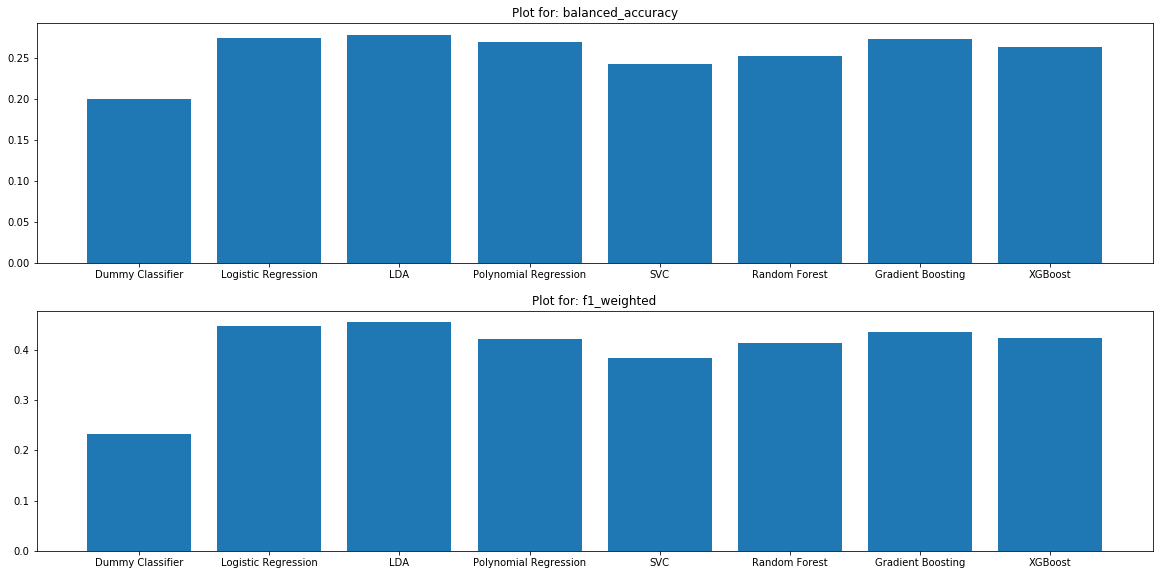

In [8]:
# params
models = {
    'Dummy Classifier': DummyClassifier(strategy = "most_frequent"), \
    'Logistic Regression': LogisticRegression(max_iter = 10000), \
    'LDA': LinearDiscriminantAnalysis(), \
    'Polynomial Regression': make_pipeline(PolynomialFeatures(2),LogisticRegression(max_iter = 10000)), \
    'SVC': SVC(), \
    'Random Forest': RandomForestClassifier(), \
    'Gradient Boosting': GradientBoostingClassifier(), \
    'XGBoost': xgb.XGBClassifier(scale_pos_weight=100) \
    }

scoring = ('balanced_accuracy', 'f1_weighted')

results_mean, results_std = perform_cross_validate(models=models, X=X_sample, y=y_sample, scoring=scoring, n_folds=3, plot=True)

In [99]:
results_mean

,Dummy Classifier,Logistic Regression,LDA,Polynomial Regression,SVC,Random Forest,Gradient Boosting,XGBoost
balanced_accuracy,0.200000,0.274359,0.278618,0.269439,0.242982,0.250970,0.271954,0.263113
f1_weighted,0.232449,0.447436,0.454855,0.421686,0.384044,0.410812,0.433607,0.424412


## 3. Select a model
**LDA and Logistic** Regression are performing well here, we will try running parameters for both and compare them.

## 4. Split training/and validation data on **the whole dataset**

In [24]:
# get data, the whole dataset that has been transformed and scaled

data = pd.read_csv('flights_scaled.csv', low_memory = False) # change this when I get the data
print(data.shape)

(15768083, 20)


In [25]:
# drop target variables used in other models and use only flight with an arrival delay > 15min (delay type is unreported)

data = data[data['delay_type'] != 0].drop(['arr_delay', 'cancelled'], axis=1)

In [26]:
# get class representations from sample (the ones listed in the intro are from the whole dataframe)

class_names = {0:  'unknown or unreported cause', 1:  'carrier_delay', 2 :'weather_delay', 3:'nas_delay', 4:'security_delay', 5: 'late_aircraft_delay'}
for c in data.delay_type.unique():
    print(f'{c} ({class_names[c]}): {len(data[data.delay_type == c])} values, {round(len(data[data.delay_type == c])/len(data)*100,2)} %')

5 (late_aircraft_delay): 1135502 values, 39.19 %
1 (carrier_delay): 763726 values, 26.36 %
3 (nas_delay): 902057 values, 31.13 %
2 (weather_delay): 91120 values, 3.14 %
4 (security_delay): 5039 values, 0.17 %


In [98]:
# export the file used for the model 
data.to_csv('db_multiclass_data.csv')

KeyboardInterrupt: 

In [27]:
# Split between target variable and dependant variables

y = data.delay_type
X = data.drop('delay_type', axis = 1)b
print(y.shape)
print(X.shape)

(2897444,)
(2897444, 17)


In [28]:
# split training and testing data set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.20, random_state=42)

In [29]:
print(y_train.shape)
print(X_train.shape)
print(y_test.shape)
print(X_test.shape)

(2317955,)
(2317955, 17)
(579489,)
(579489, 17)


<h1><center>LDA</center></h1>

## 5. Tune hyperparameters on selected algo on **training data** using grid search

In [15]:
from sklearn.model_selection import GridSearchCV

In [16]:
# samples used to try code
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split (X_sample, y_sample, test_size=0.20, random_state=42)

In [18]:
# try running model - on sample

from sklearn.metrics import f1_score # evaluation metric
from sklearn.metrics import balanced_accuracy_score # evaluation metric
from sklearn.metrics import roc_auc_score # evaluation metric

model = LinearDiscriminantAnalysis() # placeholder
model.fit(X_train_sample, y_train_sample) # fit
y_pred = model.predict(X_test_sample) # predict
y_pred_prob = model.predict_proba(X_test_sample) # predict probabilities

f1 = f1_score(y_test_sample, y_pred, average='weighted')
accuracy_balanced = balanced_accuracy_score(y_test_sample, y_pred)
auc = roc_auc_score(y_test_sample, y_pred_prob, multi_class = 'ovr')

print(f'f1: {f1}\n balanced accuracy: {accuracy_balanced} \n auc: {auc}')

f1: 0.43241964680435846
 balanced accuracy: 0.25920617386234623 
 auc: 0.7040026827609015


In [30]:
# try running model - on whole dataset - 2min

from sklearn.metrics import f1_score # evaluation metric
from sklearn.metrics import balanced_accuracy_score # evaluation metric
from sklearn.metrics import roc_auc_score # evaluation metric

model = LinearDiscriminantAnalysis() # placeholder
model.fit(X_train, y_train) # fit
y_pred = model.predict(X_test) # predict
y_pred_prob = model.predict_proba(X_test) # predict probabilities

f1 = f1_score(y_test, y_pred, average='weighted')
accuracy_balanced = balanced_accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob, multi_class = 'ovr')

print(f'f1: {f1}\n balanced accuracy: {accuracy_balanced} \n auc: {auc}')

f1: 0.45908662278743256
 balanced accuracy: 0.2845439066062655 
 auc: 0.6509309140548126


In [31]:
# perform grid search on whole dataset
# this takes 10 min

from sklearn.metrics import classification_report

# params for grid search
params = [
     {"solver": ['svd', 'lsqr', 'eigen'],
      "n_components" : [ 3, 4, 5, 6] }]

model = LinearDiscriminantAnalysis()
gsc = GridSearchCV(estimator=model, param_grid=params, n_jobs=-1)

gsc.fit(X_train, y_train)

print(gsc.best_params_)
best_model = gsc.best_estimator_
print(best_model)

{'n_components': 3, 'solver': 'svd'}
LinearDiscriminantAnalysis(n_components=3)


## 6. Train selected algo & parameters on the **training data**

In [78]:
# try model with best parameters from grid search (grid search was based on sample data)

model_LDA = best_model
model_LDA.fit(X_train, y_train) # fit

LinearDiscriminantAnalysis(n_components=3)

## 7. Test performance on **testing data**

In [94]:
y_pred = model_LDA.predict(X_test) # predict
y_pred_prob = model_LDA.predict_proba(X_test) # predict probabilities

f1 = f1_score(y_test, y_pred, average='weighted')
accuracy_balanced = balanced_accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob, multi_class = 'ovr')

print(f'f1: {f1}\n balanced accuracy: {accuracy_balanced} \n auc: {auc}')

f1: 0.45908662278743256
 balanced accuracy: 0.2845439066062655 
 auc: 0.6509309140548126


In [83]:
# get class predicted by the model
pd.DataFrame(y_pred)[0].unique()

array([3, 5, 1], dtype=int64)

### Notes
The model only predicts classes 3, 5, 1 (representing 95% of the delays)  
- nas_delay
- late_aircraft_delay
- carrier_delay

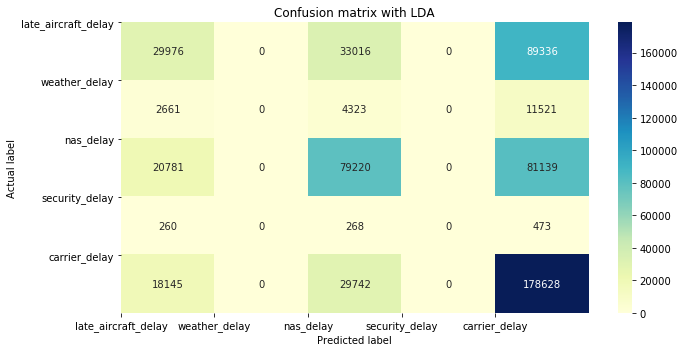

In [96]:
# print confusion matrix

# imports
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 5

# confusionn matrix
cnf_matrix_LDA = confusion_matrix(y_test, y_pred)

# create heatmap
fig, ax = plt.subplots()
sns.heatmap(pd.DataFrame(cnf_matrix_LDA), annot=True, cmap="YlGnBu" ,fmt='g')

# custom
class_names=['late_aircraft_delay','weather_delay','nas_delay','security_delay','carrier_delay']
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
plt.yticks(rotation=0)
plt.title('Confusion matrix with LDA', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()

### Notes: 
It looks like the confusion matrix doesn't take into accoun the whole dataset. let's confirm by looking at values in y_pred, y_test and the ones given by the matrix.

In [112]:
# length of y_pred and y_test
print(len(y_pred))
print(len(y_test))

579489
579489


In [111]:
cnf_matrix_LDA[:,0].sum()

71823

<h1><center>Logistic Regression</center></h1>

## 5. Tune hyperparameters on selected algo on **training data** using grid search

In [34]:
params = [
     {"penalty": ['l2', 'none'],
      "C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]}]

model = LogisticRegression(max_iter = 10000)
gsc = GridSearchCV(estimator=LogisticRegression(max_iter = 10000), param_grid=params, n_jobs=-1)

gsc.fit(X_train_sample, y_train_sample)

print(gsc.best_params_)
best_model = gsc.best_estimator_
print(best_model)

C:\Users\derob\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


{'C': 10.0, 'penalty': 'l2'}


## 6. Train selected algo & parameters on the **training data**

In [85]:
model_lr = best_model
model_lr.fit(X_train, y_train) # fit

LogisticRegression(C=10, max_iter=10000)

## 7. Test performance on **testing data**

In [98]:
y_pred = model_lr.predict(X_test) # predict
y_pred_prob = model_lr.predict_proba(X_test) # predict probabilities

f1 = f1_score(y_test, y_pred, average='weighted')
accuracy_balanced = balanced_accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob, multi_class = 'ovr')

print(f'f1: {f1}\n balanced accuracy: {accuracy_balanced} \n auc: {auc}')

f1: 0.4582718517542493
 balanced accuracy: 0.2843076957680032 
 auc: 0.6517652714817764


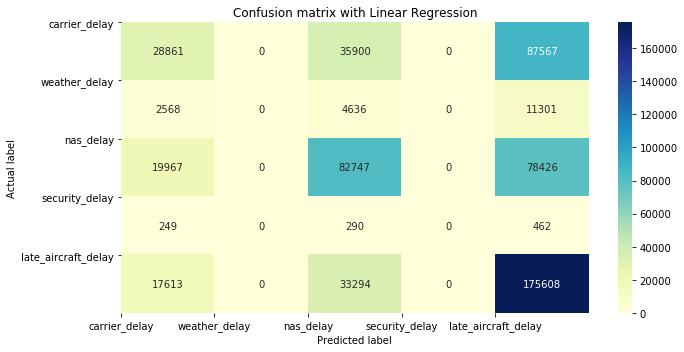

In [113]:
# print confusion matrix

cnf_matrix_lr = confusion_matrix(y_test, y_pred)

# create heatmap
fig, ax = plt.subplots()
sns.heatmap(pd.DataFrame(cnf_matrix_lr), annot=True, cmap="YlGnBu" ,fmt='g')

# custom
class_names=['carrier_delay','weather_delay','nas_delay','security_delay','late_aircraft_delay']
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
plt.yticks(rotation=0)
plt.title('Confusion matrix with Linear Regression', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()

## 8. Save with pickle
Saving LDA model

In [100]:
import pickle

In [101]:
filename = 'Multiclass.sav'
pickle.dump(model_LDA, open(filename, 'wb'))